# Proyecto Final

***Equipo 07***

- Aide Jazmín González Cruz
- Elena Villalobos Nolasco
- Carolina Acosta Tovany

#### Instrucciones

El proyecto/examen final consistirá en:

La implementación del algoritmo de filtrado colaborativo utilizando la metodología vista en clase (uso de otra metodología no se calificará).

Todos los algoritmos de aprendizaje de máquina que se utilicen deberán haber sido creados por ustedes. Sólo podrán utilizar Transformers y funciones de apoyo de scikit-learn (para realizar la división de los datos en entrenamiento y prueba, o el procedimiento de validación cruzada, etc.) mas ningún estimator (regresión logística, máquina de vectores de soporte, k medias, etc.). 

Se deberá explicar como se obtuvo la k con la que se generó el resultado final.

Se utilizarán los archivos con el conjunto pequeño de calificaciones y películas ubicado en la siguiente https://www.kaggle.com/rounakbanik/the-movies-dataset:

- **links_small.csv**: Contains the TMDB and IMDB IDs of a small subset of 9,000 movies of the Full Dataset.

- **ratings_small.csv**: The subset of 100,000 ratings from 700 users on 9,000 movies.

Con el fin de mejorar la calificación (opcional, puntos extra), se podrán utilizar los algoritmos desarrollado en las tareas del curso y los datos relevantes (los que hacen match con los datos anteriores) contenidos en los archivos:

- **movies_metadata.csv**: The main Movies Metadata file. Contains information on 45,000 movies featured in the Full MovieLens dataset. Features include posters, backdrops, budget, revenue, release dates, languages, production countries and companies.

- **keywords.csv**: Contains the movie plot keywords for our MovieLens movies. Available in the form of a stringified JSON Object.

- **credits.csv**: Consists of Cast and Crew Information for all our movies. Available in the form of a stringified JSON Object.

La métrica con la que se determinará el desempeño del algoritmo es el NDCG 

(https://en.wikipedia.org/wiki/Discounted_cumulative_gain#Normalized_DCG)

Una vez obtenida la matriz de calificaciones, el programa deberá ser capaz de regresar las 5 mejores recomendaciones del o de los usuarios que se consulten.

El proyecto se entregará en un Jupyter notebook. El readme file debe contener las instrucciones para que se ejecute el código. Deben cerciorarse que siguiendo esas instrucciones el programa corre sin errores. 

Se deberá subir a la carpeta proyecto_final/equipo_xx en el repositorio GitHub antes de las 7:00 am del día del examen final (14 de diciembre de 2020).    

In [3]:
# Importación de paqueterías necesarias
import pandas as pd
import numpy as np
import random

La función objetivo:
    
$$J(X) = \frac{1}{2} \displaystyle\sum_{(a,i)\in\mathbb{D}} \left(Y_{ai}-\left [ UV^T \right ]_{ai} \right)^2 + \frac{\lambda}{2} \displaystyle\sum_{a=1}^n \displaystyle\sum_{j=1}^k U_{aj}^2 + \frac{\lambda}{2} \displaystyle\sum_{i=1}^m \displaystyle\sum_{j=1}^k V_{ij}^2$$

In [4]:
def load_data():
    """
    Carga datos
    Regresa dataframe de Usuarios, Películas y raitings
    """
    
    # Carga de datos
    links_small = pd.read_csv('links_small.csv')
    ratings_small = pd.read_csv('ratings_small.csv')
    
    # Construyendo la matriz Y_ai
    y_ia = links_small.set_index('movieId').join(ratings_small.set_index('movieId'))
    y_ia = y_ia.reset_index()
    #y_ia.pivot(index="userId", columns="movieId", values="rating") 
    y_ia = pd.DataFrame(y_ia.pivot(index='userId', columns='movieId', values='rating'))
    y_ia = pd.DataFrame(y_ia.to_records())
    # Eliminando usuario Nan
    y_ia = y_ia[pd.notnull(y_ia['userId'])]
    # Borrando columna 1 con user_id
    y_ia = y_ia.drop(['userId'], axis=1)
    # Cambiando Nan por zeros
    Y_0 = y_ia.copy()
    Y_0[np.isnan(Y_0)] = 0

    
    return Y_0  

In [11]:
ratings = load_data()

In [13]:
n_users, n_items =  ratings.shape

In [14]:
# compute the non-zero elements in the rating matrix
matrix_size = np.prod(ratings.shape)
interaction = np.flatnonzero(ratings).shape[0]
sparsity = 100 * (interaction / matrix_size)

print('dimension: ', ratings.shape)
print('sparsity: {:.1f}%'.format(sparsity))
ratings

dimension:  (671, 9125)
sparsity: 1.6%


,1,2,3,4,5,6,7,8,9,10,...,161830,161918,161944,162376,162542,162672,163056,163949,164977,164979
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
669,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
670,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### USANDO http://ethen8181.github.io/machine-learning/recsys/1_ALSWR.html

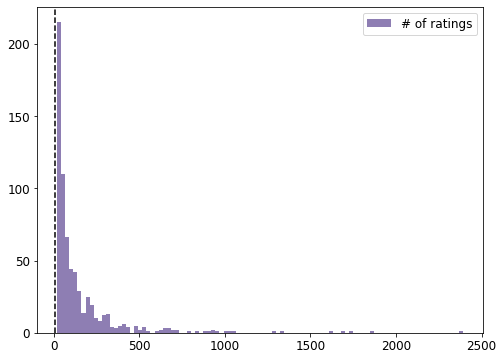

In [16]:
import matplotlib.pyplot as plt
# change default figure and font size
plt.rcParams['figure.figsize'] = 8, 6 
plt.rcParams['font.size'] = 12

plt.hist(np.sum(ratings != 0, axis = 1), histtype = 'stepfilled', bins = 100,
         alpha = 0.85, label = '# of ratings', color = '#7A68A6')
plt.axvline(x = 10, color = 'black', linestyle = '--')
plt.legend(loc = "upper right")
plt.show()

In [157]:
np.flatnonzero(ratings.shape[0])

array([0])

In [20]:
def create_train_test(ratings):
    """
    split into training and test sets,
    remove 10 ratings from each user
    and assign them to the test set
    """
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    for user in range(ratings.shape[0]):
        test_index = np.random.choice(
            np.flatnonzero(ratings[user]), size = 10, replace = False)

        train[user, test_index] = 0.0
        test[user, test_index] = ratings[user, test_index]
        
    # assert that training and testing set are truly disjoint
    assert np.all(train * test == 0)
    return train, test

train, test = create_train_test(np.array(ratings))
#del ratings
train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [5., 0., 0., ..., 0., 0., 0.]])

In [21]:
def mse_f(actual, predicted):
    sum_error = 0.0
    # loop over all values
    for i in range(len(actual)):
        # the error is the sum of (actual - prediction)^2
        prediction_error =  actual[i] - predicted[i]
        sum_error += (prediction_error ** 2)
    # now normalize
    mean_error = sum_error / float(len(actual))
    return (mean_error)

class ExplicitMF:
    """
    Train a matrix factorization model using Alternating Least Squares
    to predict empty entries in a matrix
    
    Parameters
    ----------
    n_iters : int
        number of iterations to train the algorithm
        
    n_factors : int
        number of latent factors to use in matrix 
        factorization model, some machine-learning libraries
        denote this as rank
        
    reg : float
        regularization term for item/user latent factors,
        since lambda is a keyword in python we use reg instead
    """
    # n_factors == K
    def __init__(self, n_iters, n_factors, reg):
        self.reg = reg
        self.n_iters = n_iters
        self.n_factors = n_factors  
        
    def fit(self, train, test):
        """
        pass in training and testing at the same time to record
        model convergence, assuming both dataset is in the form
        of User x Item matrix with cells as ratings
        """
        self.n_user, self.n_item = train.shape
        self.user_factors = np.random.random((self.n_user, self.n_factors))
        self.item_factors = np.random.random((self.n_item, self.n_factors))
        
        # record the training and testing mse for every iteration
        # to show convergence later (usually, not worth it for production)
        self.test_mse_record  = []
        self.train_mse_record = []   
        for _ in range(self.n_iters):
            self.user_factors = self._als_step(train, self.user_factors, self.item_factors)
            self.item_factors = self._als_step(train.T, self.item_factors, self.user_factors) 
            predictions = self.predict()
            test_mse = self.compute_mse(test, predictions)
            train_mse = self.compute_mse(train, predictions)
            self.test_mse_record.append(test_mse)
            self.train_mse_record.append(train_mse)
        
        return self    
    
    def _als_step(self, ratings, solve_vecs, fixed_vecs):
        """
        when updating the user matrix,
        the item matrix is the fixed vector and vice versa
        """
        A = fixed_vecs.T.dot(fixed_vecs) + np.eye(self.n_factors) * self.reg
        b = ratings.dot(fixed_vecs)
        A_inv = np.linalg.inv(A)
        solve_vecs = b.dot(A_inv)
        return solve_vecs
    
    def predict(self):
        """predict ratings for every user and item"""
        pred = self.user_factors.dot(self.item_factors.T)
        return pred
    
    @staticmethod
    def compute_mse(y_true, y_pred):
        """ignore zero terms prior to comparing the mse"""
        mask = np.nonzero(y_true)
        #print("mask: ",mask)
        # con skyleran
        #mse = mean_squared_error(y_true[mask], y_pred[mask])
        #print("mse: ", mse)
        mse = mse_f(y_true[mask], y_pred[mask])
        #print("mse2: ", mse2)
        return mse
    
def plot_learning_curve(model):
    """visualize the training/testing loss"""
    linewidth = 3
    plt.plot(model.test_mse_record, label = 'Test', linewidth = linewidth,col='r')
    plt.plot(model.train_mse_record, label = 'Train', linewidth = linewidth,col='c')
    plt.xlabel('iterations')
    plt.ylabel('MSE')

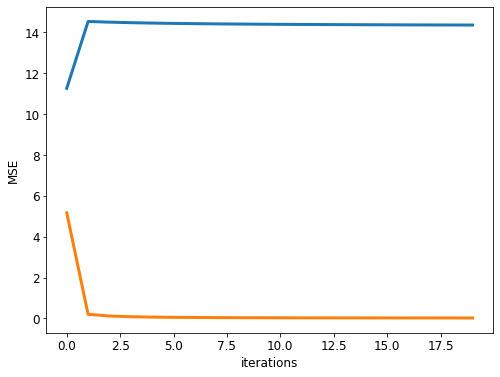

In [49]:
als = ExplicitMF(n_iters = 20, n_factors = 600, reg = 1)
als.fit(train, test)
plot_learning_curve(als)

In [50]:
K = 5

In [51]:
K_list = []
for i in range(1, train.shape[0], 200):
    K_list.append(i)

In [73]:
K_list

[10, 71, 171, 271, 371, 471, 571, 671]

In [72]:
K_list = [10,71,171,271,371,471,571,671]

In [53]:
df_k = pd.DataFrame(0.0, index=range(1), columns=K_list)
data = train

In [54]:
data.shape

(671, 9125)

In [55]:
# Dividimos los datos en chunk de igual tamaño de forma vertical
chunks = np.hsplit(data, K)
for k in K_list:
    error = 0.0
    for i in range(1, int(K)):

        # El chunk i será nuestro bloque de datos de prueba
        test_data = chunks[i]

        # Entrenamos con todos los otros datos menos con el chunk[i]
        train_data = chunks.copy()
        train_data.pop(i)
        train_data = np.concatenate(train_data)
        
        als = ExplicitMF(n_iters = 15, n_factors = k, reg = 0.01)
        als.fit(train, test)
        error += np.mean(als.test_mse_record)
    error /= K

    df_k[k][0] = error

#df_k.idxmin(axis=1)[0]
df_k

,1,201,401,601
0,9.813798,9.818272,11.041103,11.497395


In [57]:
from sklearn.model_selection import KFold

In [58]:
n_splits = 5
max_epochs = 15
kf = KFold(n_splits=n_splits, random_state=0, shuffle=True)

In [62]:
k_list = [1, 2, 5, 10, 20, 50, 100]
small_df = ratings

In [63]:
small_df

,1,2,3,4,5,6,7,8,9,10,...,161830,161918,161944,162376,162542,162672,163056,163949,164977,164979
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
669,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
670,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [65]:
train_errs = np.zeros((n_splits, len(k_list)))
test_errs = np.zeros((n_splits, len(k_list)))

In [67]:
train_errs

array([[0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.]])

In [68]:
test_errs

array([[0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.]])

In [71]:
for i_fold, (train_inds, test_inds) in enumerate(kf.split(small_df)):
    print("i_fold={}: ".format(i_fold), end='')
    train_df, test_df = small_df.iloc[train_inds], small_df.iloc[test_inds]
    #baseline_algo = DampedUserMovieBaselineModel(damping_factor=10)
    for i_k, k in enumerate(k_list):
        print("k={}, ".format(k), end='')
        rec = ExplicitMF(n_iters = 15, n_factors = k, reg = 0.01)
        rec.fit(train_df,test_df)
        #preds = rec.predict(test_df[['userId', 'movieId']])
        #test_err = compute_mse(preds, test_df['rating'])
        #test_errs[i_fold, i_k] = test_err
        #train_errs[i_fold, i_k] = rec.train_errors[-1]
    print()

i_fold=0: k=1, 

ValueError: Shape of passed values is (2, 23383), indices imply (135, 9125)